# Usage Example

- How to generate a DRR
- How to gradients with respect to DRR parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from diffdrr import load_example_ct, DRR
from diffdrr.visualization import plot_drr

## DRR Generation

The generator is implemented as a custom PyTorch module.

All raytracing operations have been formulated in a vectorized function, enabling use of PyTorch's GPU support and autograd.
This also means that DRR generation is available as a layer in deep learning frameworks.

Timing results are on a single NVIDIA RTX 2080 Ti GPU.

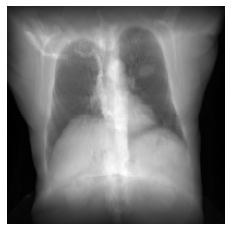

In [2]:
# Read in the volume
volume, spacing = load_example_ct()

# Get parameters for the detector
bx, by, bz = np.array(volume.shape) * np.array(spacing) / 2
detector_kwargs = {
    "sdr"   : 300.0,
    "theta" : torch.pi,
    "phi"   : 0,
    "gamma" : torch.pi / 2,
    "bx"    : bx,
    "by"    : by,
    "bz"    : bz,
}

# Make the DRR
drr = DRR(volume, spacing, height=200, delx=1.4e-2, device="cuda")
img = drr(**detector_kwargs)  # Parameters need to be initialized only once

ax = plot_drr(img)
ax.axis("off")
plt.savefig("../figures/example_DRR.pdf", bbox_inches="tight")
plt.show()

In [3]:
%timeit drr()

69.3 ms ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Gradients

Gradients of input parameters are computable with autograd.

In [4]:
img.mean().backward()
drr.rotations.grad, drr.translations.grad

(tensor([6230.1045, -100.1516, 8068.8228], device='cuda:0'),
 tensor([ 8.1455e+02,  2.2619e-01, -4.3657e+01], device='cuda:0'))

## Try the M1 GPU

Certain PyTorch functions have not yet been ported :(

In [5]:
# Make DRR
drr = DRR(volume, spacing, height=200, delx=1.4e-2, device="mps")
img = drr(**detector_kwargs)

plot_drr(drr)
plt.show()

ValueError: mps is not available